In [1]:
#Standard Imports 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
import numpy as np
%matplotlib inline
print_switch = True

In [2]:
df1 = pd.read_csv('./data_in/BRK-A.csv')

In [3]:
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,290.0,310.0,290.0,290.0,290.0,10000
1,1980-03-18,290.0,290.0,290.0,290.0,290.0,0
2,1980-03-19,290.0,310.0,290.0,290.0,290.0,20000
3,1980-03-20,290.0,290.0,290.0,290.0,290.0,0
4,1980-03-21,290.0,290.0,290.0,290.0,290.0,0


In [4]:
df1.shape

(9951, 7)

In [5]:
df1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
9946,2019-08-26,298100.0,300899.0,297540.0,300899.0,300899.0,200
9947,2019-08-27,300821.0,302000.0,298000.0,298420.0,298420.0,200
9948,2019-08-28,297955.0,301300.0,297387.0,300990.0,300990.0,200
9949,2019-08-29,303400.0,305975.0,303100.0,305040.0,305040.0,300
9950,2019-08-30,306750.0,306829.0,303078.0,303078.0,303078.0,200


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9951 entries, 0 to 9950
Data columns (total 7 columns):
Date         9951 non-null object
Open         9951 non-null float64
High         9951 non-null float64
Low          9951 non-null float64
Close        9951 non-null float64
Adj Close    9951 non-null float64
Volume       9951 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 544.3+ KB


In [7]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9951 entries, 0 to 9950
Data columns (total 7 columns):
Date         9951 non-null datetime64[ns]
Open         9951 non-null float64
High         9951 non-null float64
Low          9951 non-null float64
Close        9951 non-null float64
Adj Close    9951 non-null float64
Volume       9951 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 544.3 KB


In [9]:
df1.columns = df1.columns.str.upper().str.replace(' ', '_')

In [10]:
df1.head()

,DATE,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME
0,1980-03-17,290.0,310.0,290.0,290.0,290.0,10000
1,1980-03-18,290.0,290.0,290.0,290.0,290.0,0
2,1980-03-19,290.0,310.0,290.0,290.0,290.0,20000
3,1980-03-20,290.0,290.0,290.0,290.0,290.0,0
4,1980-03-21,290.0,290.0,290.0,290.0,290.0,0


/Users/gta/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


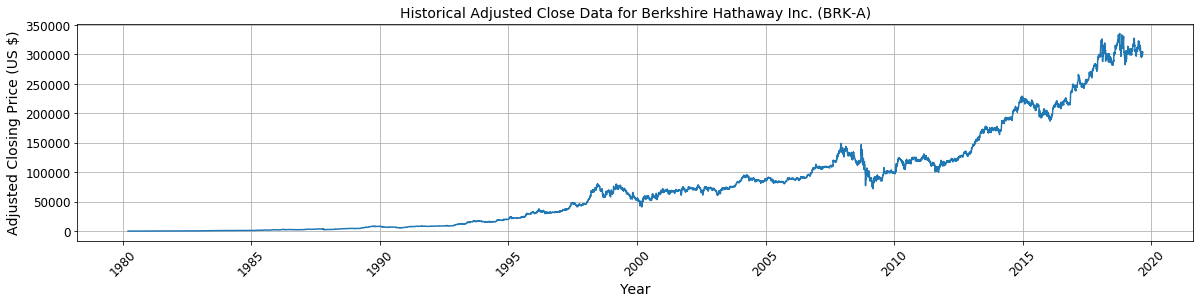

In [11]:
plt.figure(figsize=(20, 4))
plt.plot(df1['DATE'], df1['ADJ_CLOSE'])
plt.title('Historical Adjusted Close Data for Berkshire Hathaway Inc. (BRK-A)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Adjusted Closing Price (US $)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [12]:
df = df1.loc[:,['DATE', 'ADJ_CLOSE', 'VOLUME']]

# Developing the testing/training sets based on the pre-determined size (`train_test_split`).

### Option 1

Option 1 uses a sliding 30-day look back window to estimate the 31st data point. This solves the problem with doing cross validation on time-series data.

In [13]:
#https://robjhyndman.com/hyndsight/tscv/
#https://machinelearningmastery.com/index-slice-reshape-numpy-arrays-machine-learning-python/

tot_training_points = df.shape[0] - 30 #Offsetting the start of the data by 30 days.
testing_period = 1                     #Doing a one-day forecast for testing (counterfactual).
train_test_split_ratio = 0.8

#Creates a 2D matrix of sample idx where each row is a 1D vector of 30 training points and one testing point.
#The number of rows is equal to the total number of training points in the dataset.
sample_idx = np.arange(tot_training_points).reshape(-1, 1) + np.arange(30 + testing_period)

#Creates 2D matrix that has a sliding window of training and testing data.
cv_matrix = df['ADJ_CLOSE'].values[sample_idx]

#Takes all rows, and everything except the last column.
X = cv_matrix[:,:-1] 

#Takes all rows, and the last column.
y = cv_matrix[:,-1]

#Finds idx that splits the data into the training and testing set.
train_test_split_idx = int(train_test_split_ratio * tot_training_points)

#Take all points until from 0 up to the train_test_split_idx
X_train = X[:train_test_split_idx]
y_train = y[:train_test_split_idx]

#Take all points from the train_test_split_idx until the end of the array.
X_test = X[train_test_split_idx:]
y_test = y[train_test_split_idx:]

In [14]:
cv_matrix.shape

(9921, 31)

In [15]:
def residual(df, y_test, y_pred, title_string):
    plt.figure(figsize=(20, 4))
    
    delta = y_test - y_pred

    plt.plot(df['DATE'][-X_test.shape[0]:], 
             delta, 
             color='k', 
             alpha=0.5)

    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Actual vs. Predicted Differential', fontsize=14)
    plt.title('Residual Plot for Berkshire Hathaway Inc. (BRK-A) ' + title_string, fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()
    
def plot_data(df, y_test, y_pred, title_string):
    plt.figure(figsize=(20, 4))

    plt.plot(df['DATE'][-X_test.shape[0]:], 
             y_pred, 
             color='k', 
             alpha=0.5, 
             label='Predicted')

    plt.plot(df['DATE'][-X_test.shape[0]:], 
             y_test, 
             color='g', 
             alpha=0.5, 
             label='Actual')

    plt.legend(loc='upper left')
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Adjusted Closing Price (US $)', fontsize=14)
    plt.title('Historical Adjusted Close Data for Berkshire Hathaway Inc. (BRK-A) ' + title_string, fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.ylim(0, 400000)
    plt.grid(True)
    plt.show()

### Model 1:  Simple Linear Model
`https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html`

In [16]:
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('The R^2 of the linear model is: {0:.3f}'.format(lr.score(X_test, y_test)))

The R^2 of the linear model is: 0.999


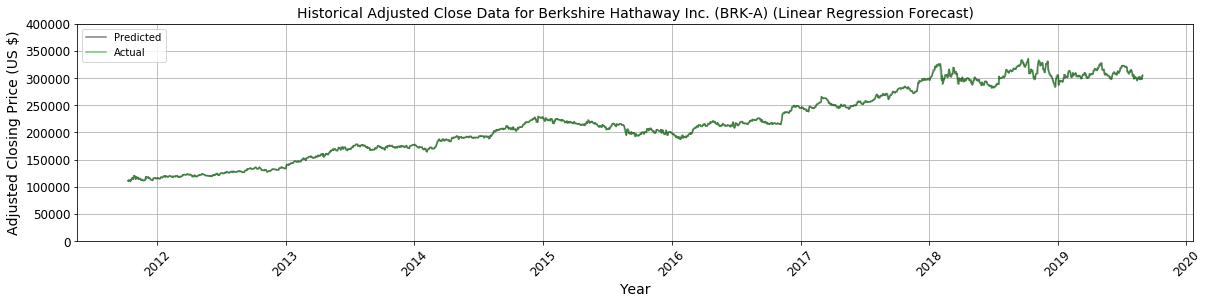

In [17]:
plot_data(df=df, y_test=y_test, y_pred=y_pred_lr, title_string='(Linear Regression Forecast)')

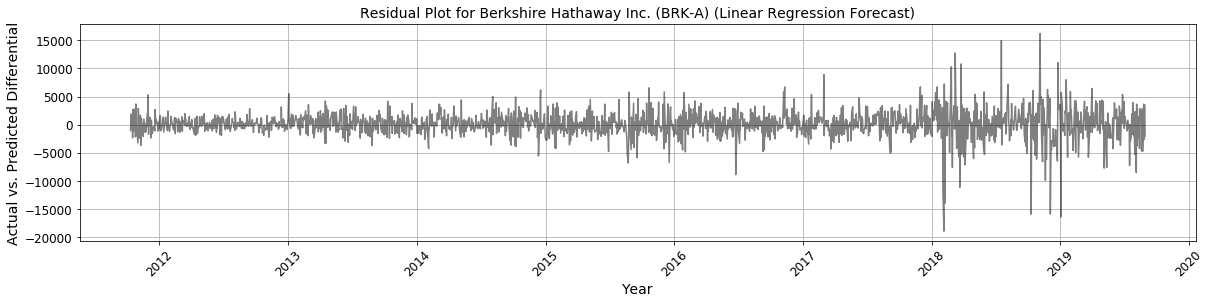

In [18]:
residual(df=df, y_test=y_test, y_pred=y_pred_lr, title_string='(Linear Regression Forecast)')

### Model 2:  K-Nearest Neighbors (kNN) Regression 
`https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html`

In [19]:
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print('The R^2 of the kNN model is: {0:.3f}'.format(knn.score(X_test, y_test)))

The R^2 of the kNN model is: -1.741


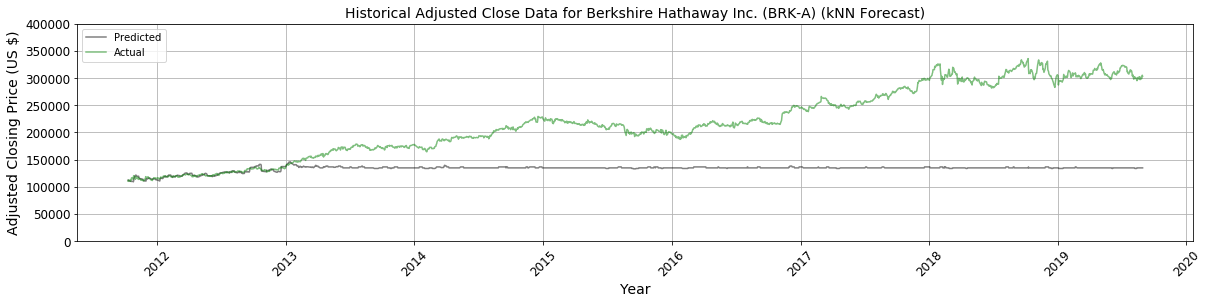

In [20]:
plot_data(df=df, y_test=y_test, y_pred=y_pred_knn, title_string='(kNN Forecast)')

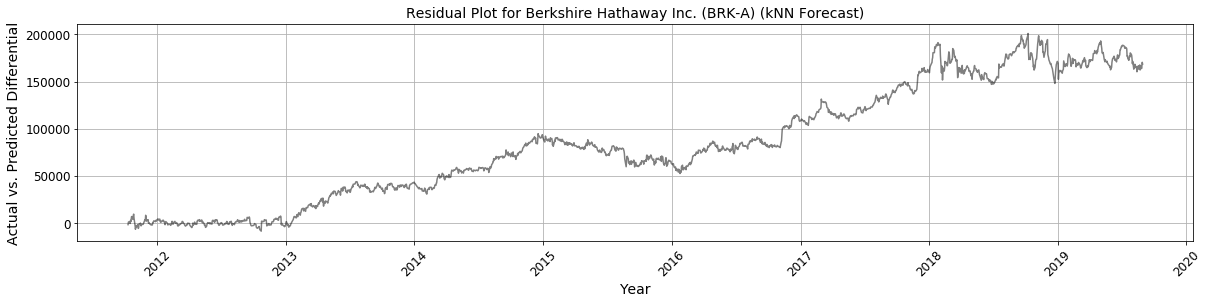

In [21]:
residual(df=df, y_test=y_test, y_pred=y_pred_knn, title_string='(kNN Forecast)')

### Model 3:  Ridge Regression
`https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html`

In [22]:
ridge = Ridge(random_state=42).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print('The R^2 of the ridge model is: {0:.3f}'.format(ridge.score(X_test, y_test)))

The R^2 of the ridge model is: 0.999


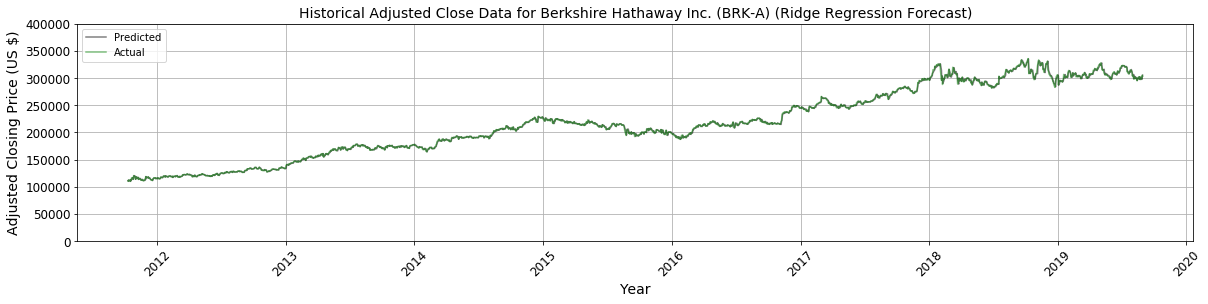

In [23]:
plot_data(df=df, y_test=y_test, y_pred=y_pred_ridge, title_string='(Ridge Regression Forecast)')

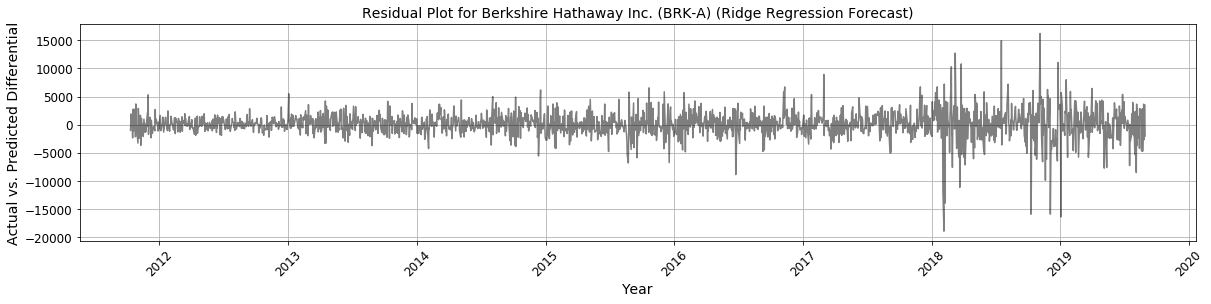

In [24]:
residual(df=df, y_test=y_test, y_pred=y_pred_ridge, title_string='(Ridge Regression Forecast)')

## Option 1 Outputs

In [25]:
if print_switch == True:
    opt1_y_pred_lr_df = pd.DataFrame({'date': df['DATE'][-X_test.shape[0]:],'forecast': y_pred_lr,'actual': y_test})
    opt1_y_pred_knn_df = pd.DataFrame({'date': df['DATE'][-X_test.shape[0]:],'forecast': y_pred_knn,'actual': y_test})
    opt1_y_pred_ridge_df = pd.DataFrame({'date': df['DATE'][-X_test.shape[0]:],'forecast': y_pred_ridge,'actual': y_test})

    opt1_y_pred_lr_df.to_csv('./data_out/opt1_y_pred_lr_df.csv', index=False)
    opt1_y_pred_knn_df.to_csv('./data_out/opt1_y_pred_knn_df.csv', index=False)
    opt1_y_pred_ridge_df.to_csv('./data_out/opt1_y_pred_ridge_df.csv', index=False)

### Option 2

In [26]:
df['HL_PCT'] = ((df1['HIGH'] - df1['LOW']) / df1['CLOSE']) * 100
df['DELTA_PCT'] = ((df1['CLOSE'] - df1['OPEN']) / df1['OPEN']) *100
df.head()

,DATE,ADJ_CLOSE,VOLUME,HL_PCT,DELTA_PCT
0,1980-03-17,290.0,10000,6.896552,0.0
1,1980-03-18,290.0,0,0.000000,0.0
2,1980-03-19,290.0,20000,6.896552,0.0
3,1980-03-20,290.0,0,0.000000,0.0
4,1980-03-21,290.0,0,0.000000,0.0


In [27]:
df.tail()

,DATE,ADJ_CLOSE,VOLUME,HL_PCT,DELTA_PCT
9946,2019-08-26,300899.0,200,1.116321,0.938947
9947,2019-08-27,298420.0,200,1.340393,-0.798149
9948,2019-08-28,300990.0,200,1.300043,1.018610
9949,2019-08-29,305040.0,300,0.942499,0.540541
9950,2019-08-30,303078.0,200,1.237635,-1.197066


In [28]:
cv_matrix = df[['VOLUME', 'HL_PCT', 'DELTA_PCT', 'ADJ_CLOSE']].values

In [29]:
tot_training_points = df.shape[0]

#Takes all rows, and everything except the last column.
X = cv_matrix[:,:-1] 

#Takes all rows, and the last column.
y = cv_matrix[:,-1]

#Finds idx that splits the data into the training and testing set.
train_test_split_idx = int(train_test_split_ratio * tot_training_points)

#Take all points until from 0 up to the train_test_split_idx
X_train = X[:train_test_split_idx]
y_train = y[:train_test_split_idx]

#Take all points from the train_test_split_idx until the end of the array.
X_test = X[train_test_split_idx:]
y_test = y[train_test_split_idx:]

### Model 1:  Simple Linear Model
`https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html`

In [30]:
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('The R^2 of the linear model is: {0:.3f}'.format(lr.score(X_test, y_test)))

The R^2 of the linear model is: -8.203


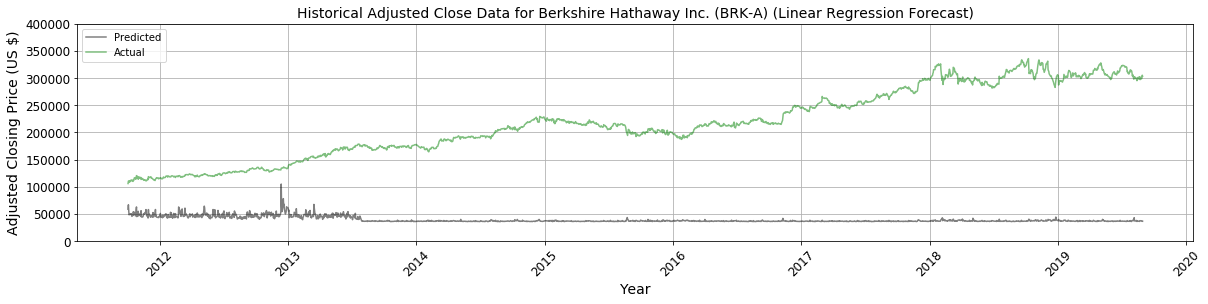

In [31]:
plot_data(df=df, y_test=y_test, y_pred=y_pred_lr, title_string='(Linear Regression Forecast)')

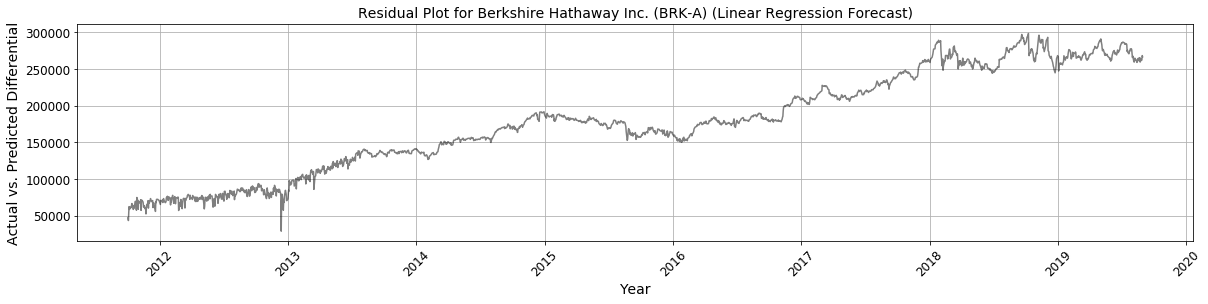

In [32]:
residual(df=df, y_test=y_test, y_pred=y_pred_lr, title_string='(Linear Regression Forecast)')

### Model 2:  K-Nearest Neighbors (kNN) Regression 
`https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html`

In [33]:
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print('The R^2 of the kNN model is: {0:.3f}'.format(knn.score(X_test, y_test)))

The R^2 of the kNN model is: -10.494


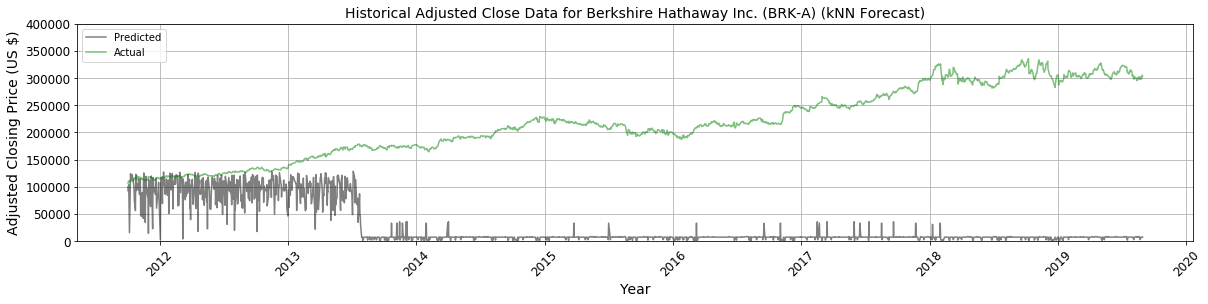

In [34]:
plot_data(df=df, y_test=y_test, y_pred=y_pred_knn, title_string='(kNN Forecast)')

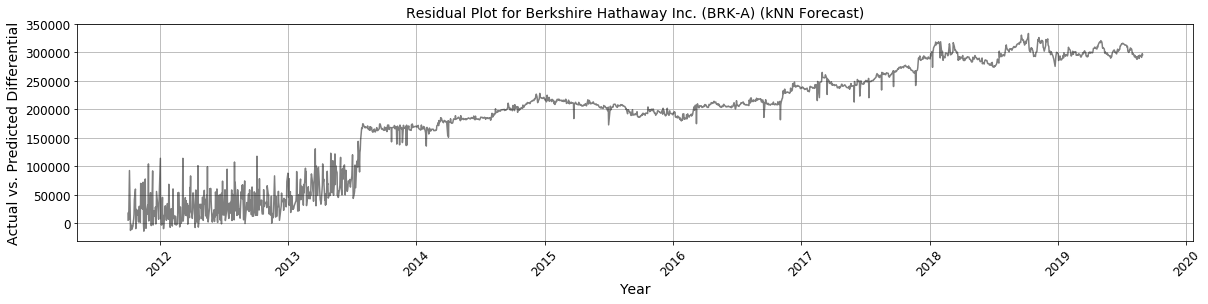

In [35]:
residual(df=df, y_test=y_test, y_pred=y_pred_knn, title_string='(kNN Forecast)')

### Model 3:  Ridge Regression
`https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html`

In [36]:
ridge = Ridge(random_state=42).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print('The R^2 of the ridge model is: {0:.3f}'.format(ridge.score(X_test, y_test)))

The R^2 of the ridge model is: -8.203


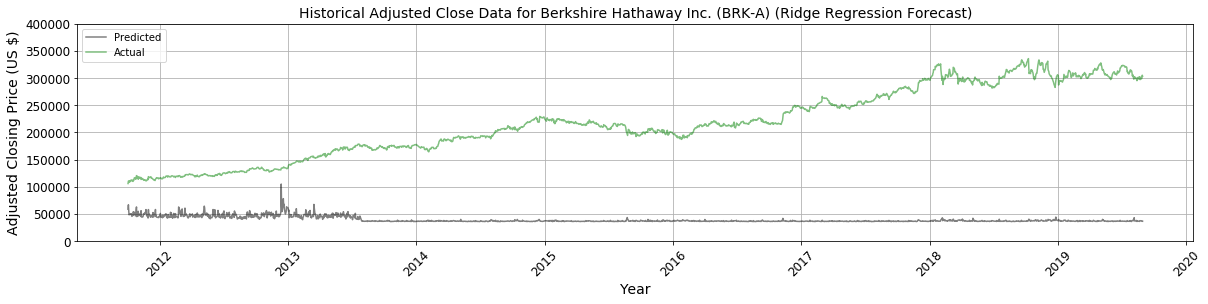

In [37]:
plot_data(df=df, y_test=y_test, y_pred=y_pred_ridge, title_string='(Ridge Regression Forecast)')

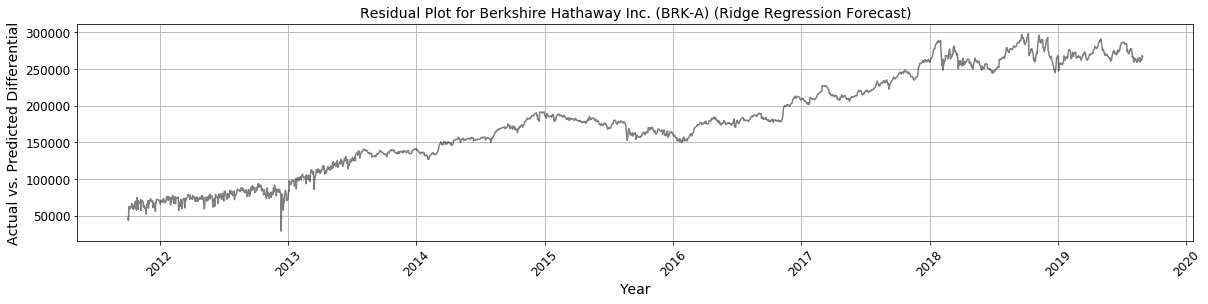

In [38]:
residual(df=df, y_test=y_test, y_pred=y_pred_ridge, title_string='(Ridge Regression Forecast)')

### Option 2 Outputs

In [39]:
if print_switch == True:
    opt2_y_pred_lr_df = pd.DataFrame({'date': df['DATE'][-X_test.shape[0]:],'forecast': y_pred_lr,'actual': y_test})
    opt2_y_pred_knn_df = pd.DataFrame({'date': df['DATE'][-X_test.shape[0]:],'forecast': y_pred_knn,'actual': y_test})
    opt2_y_pred_ridge_df = pd.DataFrame({'date': df['DATE'][-X_test.shape[0]:],'forecast': y_pred_ridge,'actual': y_test})

    opt2_y_pred_lr_df.to_csv('./data_out/opt2_y_pred_lr_df.csv', index=False)
    opt2_y_pred_knn_df.to_csv('./data_out/opt2_y_pred_knn_df.csv', index=False)
    opt2_y_pred_ridge_df.to_csv('./data_out/opt2_y_pred_ridge_df.csv', index=False)